In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install face_recognition dlib heartpy torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.9 MB/s eta 0:00:00
  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 190MB/s]
Epoch 1/5: 100%|██████████| 921/921 [21:31<00:00,  1.40s/it, acc=57.7, loss=0.671]

Epoch 1 Train Loss: 0.6710 | Train Acc: 57.66%


Validation Loss: 0.6677 | Validation Acc: 57.79%


Epoch 2/5: 100%|██████████| 921/921 [12:46<00:00,  1.20it/s, acc=60.9, loss=0.655]

Epoch 2 Train Loss: 0.6547 | Train Acc: 60.89%


Validation Loss: 0.6567 | Validation Acc: 62.74%


Epoch 3/5: 100%|██████████| 921/921 [12:37<00:00,  1.22it/s, acc=62.8, loss=0.642]

Epoch 3 Train Loss: 0.6419 | Train Acc: 62.76%


Validation Loss: 0.6336 | Validation Acc: 64.51%


Epoch 4/5: 100%|██████████| 921/921 [12:39<00:00,  1.21it/s, acc=65.6, loss=0.62]

Epoch 4 Train Loss: 0.6200 | Train Acc: 65.59%


Validation Loss: 0.6313 | Validation Acc: 63.88%


Epoch 5/5: 100%|██████████| 921/921 [12:38<00:00,  1.21it/s, acc=67, loss=0.602]

Epoch 5 Train Loss: 0.6023 | Train Acc: 66.97%


Validation Loss: 0.5977 | Validation Acc: 69.33%
Training complete.


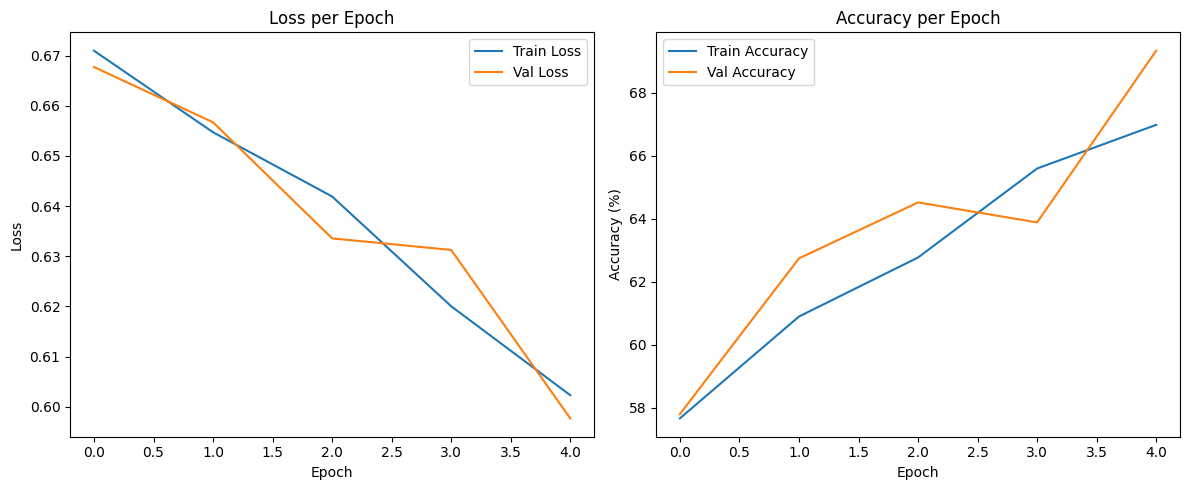

Evaluating: 100%|██████████| 198/198 [04:31<00:00,  1.37s/it]


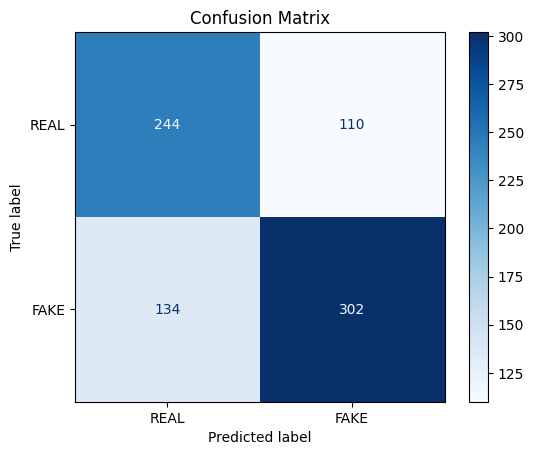

Classification Report:
               precision    recall  f1-score   support

        REAL       0.65      0.69      0.67       354
        FAKE       0.73      0.69      0.71       436

    accuracy                           0.69       790
   macro avg       0.69      0.69      0.69       790
weighted avg       0.69      0.69      0.69       790



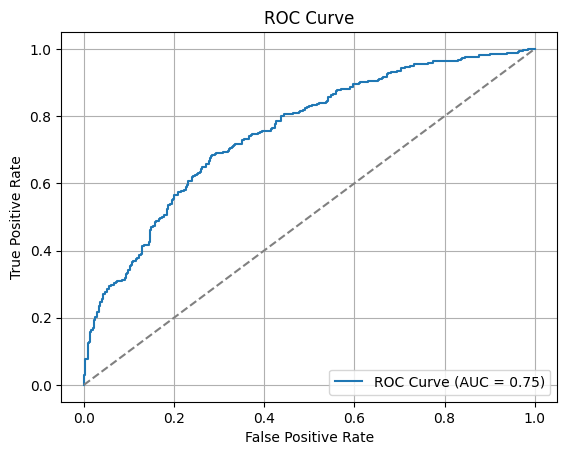

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import face_recognition
import heartpy as hp

# === Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === Device setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Hyperparameters ===
NUM_FRAMES = 16
BATCH_SIZE = 4
EPOCHS = 5
LR = 1e-4
FEATURE_SIZE = 512
HIDDEN_SIZE = 128
NUM_CLASSES = 2

# === Path Setup ===
base_path = "/content/drive/MyDrive/deepfake_data"
folders = [
    "Celeb_fake_face_only",
    "Celeb_real_face_only",
    "DFDC_FAKE_Face_only_data",
    "DFDC_REAL_Face_only_data",
    "FF_Face_only_data"
]

# === Build a video path lookup from filename to full path ===
video_path_map = {}
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for fname in os.listdir(folder_path):
        if fname.endswith(".mp4"):
            full_path = os.path.join(folder, fname)  # relative to base_path
            video_path_map[fname] = full_path

# === Load metadata and map filenames to full relative paths ===
metadata_df = pd.read_csv('/content/Global_metadata.csv')

# Add new column with full relative path to video
metadata_df["video_path_full"] = metadata_df["video_path"].map(video_path_map)

# Drop rows where video was not found
missing_count = metadata_df["video_path_full"].isna().sum()
if missing_count > 0:
    print(f"Warning: {missing_count} videos in CSV not found in folders. Dropping them.")
metadata_df = metadata_df.dropna(subset=["video_path_full"])

# === Transforms ===
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === rPPG Extraction helper ===
def extract_rppg_signal(video_path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Warning: Cannot open video {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        print(f"Warning: Video {video_path} has 0 frames")
        cap.release()
        return None

    frame_indices = []
    if total_frames < num_frames:
        frame_indices = [i % total_frames for i in range(num_frames)]
    else:
        interval = total_frames // num_frames
        frame_indices = [i * interval for i in range(num_frames)]

    green_signals = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            if green_signals:
                green_signals.append(green_signals[-1])
            else:
                green_signals.append(0)
            continue

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Face detection with face_recognition (using largest face if multiple)
        face_locations = face_recognition.face_locations(rgb_frame)
        if not face_locations:
            # No face found, append zero or last signal
            if green_signals:
                green_signals.append(green_signals[-1])
            else:
                green_signals.append(0)
            continue

        # Get biggest face bounding box
        top, right, bottom, left = max(face_locations, key=lambda rect: (rect[2] - rect[0]) * (rect[1] - rect[3]))

        face_region = rgb_frame[top:bottom, left:right]
        if face_region.size == 0:
            green_signals.append(0)
            continue

        # Extract mean green channel intensity from face region
        mean_green = np.mean(face_region[:, :, 1])
        green_signals.append(mean_green)

    cap.release()

    # Normalize signal
    green_signals = np.array(green_signals)
    green_signals = (green_signals - np.mean(green_signals)) / (np.std(green_signals) + 1e-6)

    # Use heartpy to extract heart rate features from the signal
    try:
        wd, m = hp.process(green_signals, sample_rate=30.0)  # Assume 30 FPS for videos
        features = np.array([
            m['bpm'],
            m['ibi'],
            m['sdnn'],
            m['rmssd'],
            m['pnn20'],
            m['pnn50'],
            m['heart_rate_std'],
        ])
    except Exception as e:
        # If heartpy fails, fallback to zeros
        features = np.zeros(7)

    features = torch.tensor(features, dtype=torch.float32)
    return features

# === Dataset Class ===
class DeepFakeVideoDataset(Dataset):
    def __init__(self, df, root_dir, num_frames=NUM_FRAMES, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.transform = transform
        self.label_map = {'REAL': 0, 'FAKE': 1}

    def __len__(self):
        return len(self.df)

    def _extract_frames(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Warning: Cannot open video {video_path}")
            return None

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames == 0:
            print(f"Warning: Video {video_path} has 0 frames")
            cap.release()
            return None

        frame_indices = []
        if total_frames < self.num_frames:
            frame_indices = [i % total_frames for i in range(self.num_frames)]
        else:
            interval = total_frames // self.num_frames
            frame_indices = [i * interval for i in range(self.num_frames)]

        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                if frames:
                    frames.append(frames[-1])
                else:
                    frames.append(np.zeros((224, 224, 3), dtype=np.uint8))
                continue
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)

        cap.release()
        frames = torch.stack(frames)
        return frames

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        video_rel_path = row['video_path_full']
        label_str = row['label'].upper()
        label = self.label_map.get(label_str, 0)
        video_full_path = os.path.join(self.root_dir, video_rel_path)

        frames = self._extract_frames(video_full_path)
        if frames is None:
            frames = torch.zeros(self.num_frames, 3, 224, 224)

        rppg_features = extract_rppg_signal(video_full_path)
        if rppg_features is None:
            rppg_features = torch.zeros(7)  # fallback

        return frames, rppg_features, label

# === Split dataset ===
train_df, temp_df = train_test_split(metadata_df, test_size=0.3, stratify=metadata_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# === Dataset and DataLoader ===
train_dataset = DeepFakeVideoDataset(train_df, base_path, num_frames=NUM_FRAMES, transform=transform)
val_dataset = DeepFakeVideoDataset(val_df, base_path, num_frames=NUM_FRAMES, transform=transform)

test_dataset = DeepFakeVideoDataset(test_df, base_path, num_frames=NUM_FRAMES, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# === Model ===
class ResNeXtLSTMWithRPPGClassifier(nn.Module):
    def __init__(self, feature_size=FEATURE_SIZE, hidden_size=HIDDEN_SIZE, rppg_feature_size=7, num_layers=1, num_classes=NUM_CLASSES):
        super(ResNeXtLSTMWithRPPGClassifier, self).__init__()
        resnext = models.resnext50_32x4d(weights='ResNeXt50_32X4D_Weights.DEFAULT')
        self.feature_extractor = nn.Sequential(*list(resnext.children())[:-1])
        self.feature_reducer = nn.Linear(2048, feature_size)
        self.lstm = nn.LSTM(input_size=feature_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        # Combine LSTM output with rPPG features
        self.combined_fc = nn.Linear(hidden_size + rppg_feature_size, 64)
        self.classifier = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x, rppg_features):
        batch_size, seq_len, C, H, W = x.size()
        x = x.view(batch_size * seq_len, C, H, W)

        with torch.no_grad():
            features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        features = self.feature_reducer(features)

        features = features.view(batch_size, seq_len, -1)
        lstm_out, _ = self.lstm(features)
        lstm_out = lstm_out[:, -1, :]

        combined = torch.cat((lstm_out, rppg_features), dim=1)
        combined = self.relu(self.combined_fc(combined))
        out = self.classifier(combined)
        return out

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# === Train Loop ===
model = ResNeXtLSTMWithRPPGClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for inputs, rppg_feats, labels in loop:
        inputs, rppg_feats, labels = inputs.to(device), rppg_feats.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, rppg_feats)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    print(f"Epoch {epoch+1} Train Loss: {running_loss / total:.4f} | Train Acc: {100. * correct / total:.2f}%")

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, rppg_feats, labels in val_loader:
            inputs, rppg_feats, labels = inputs.to(device), rppg_feats.to(device), labels.to(device)
            outputs = model(inputs, rppg_feats)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss / val_total:.4f} | Validation Acc: {100. * val_correct / val_total:.2f}%")

    # Track metrics
    train_loss_history.append(running_loss / total)
    train_acc_history.append(100. * correct / total)
    val_loss_history.append(val_loss / val_total)
    val_acc_history.append(100. * val_correct / val_total)


print("Training complete.")

# === After training, plot training/validation loss and accuracy ===
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

# === Test Evaluation ===
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve

all_preds = []
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, rppg_feats, labels in tqdm(test_loader, desc="Evaluating"):
        inputs, rppg_feats = inputs.to(device), rppg_feats.to(device)
        outputs = model(inputs, rppg_feats)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1 (FAKE)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['REAL', 'FAKE'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=['REAL', 'FAKE']))

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [ ]:
torch.save(model, 'resnext_lstm_rppg_model_full.pth')
print("Full model saved successfully!")


Full model saved successfully!


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import numpy as np
import face_recognition
import heartpy as hp
import os

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

NUM_FRAMES = 16
FEATURE_SIZE = 512
HIDDEN_SIZE = 128
NUM_CLASSES = 2

# === Load the same model class ===
class ResNeXtLSTMWithRPPGClassifier(nn.Module):
    def __init__(self, feature_size=FEATURE_SIZE, hidden_size=HIDDEN_SIZE, rppg_feature_size=7, num_layers=1, num_classes=NUM_CLASSES):
        super(ResNeXtLSTMWithRPPGClassifier, self).__init__()
        resnext = models.resnext50_32x4d(weights='ResNeXt50_32X4D_Weights.DEFAULT')
        self.feature_extractor = nn.Sequential(*list(resnext.children())[:-1])
        self.feature_reducer = nn.Linear(2048, feature_size)
        self.lstm = nn.LSTM(input_size=feature_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.combined_fc = nn.Linear(hidden_size + rppg_feature_size, 64)
        self.classifier = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x, rppg_features):
        batch_size, seq_len, C, H, W = x.size()
        x = x.view(batch_size * seq_len, C, H, W)
        with torch.no_grad():
            features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        features = self.feature_reducer(features)
        features = features.view(batch_size, seq_len, -1)
        lstm_out, _ = self.lstm(features)
        lstm_out = lstm_out[:, -1, :]
        combined = torch.cat((lstm_out, rppg_features), dim=1)
        combined = self.relu(self.combined_fc(combined))
        out = self.classifier(combined)
        return out

# === Transforms ===
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === rPPG Feature Extraction ===
def extract_rppg_signal(video_path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Failed to open video:", video_path)
        return torch.zeros(7)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = [i * (total_frames // num_frames) for i in range(num_frames)]

    green_signals = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            green_signals.append(green_signals[-1] if green_signals else 0)
            continue
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        face_locations = face_recognition.face_locations(rgb_frame)
        if not face_locations:
            green_signals.append(green_signals[-1] if green_signals else 0)
            continue
        top, right, bottom, left = max(face_locations, key=lambda rect: (rect[2] - rect[0]) * (rect[1] - rect[3]))
        face_region = rgb_frame[top:bottom, left:right]
        if face_region.size == 0:
            green_signals.append(0)
            continue
        mean_green = np.mean(face_region[:, :, 1])
        green_signals.append(mean_green)

    cap.release()
    green_signals = np.array(green_signals)
    green_signals = (green_signals - np.mean(green_signals)) / (np.std(green_signals) + 1e-6)
    try:
        wd, m = hp.process(green_signals, sample_rate=30.0)
        features = np.array([
            m['bpm'], m['ibi'], m['sdnn'], m['rmssd'],
            m['pnn20'], m['pnn50'], m['heart_rate_std'],
        ])
    except Exception:
        features = np.zeros(7)

    return torch.tensor(features, dtype=torch.float32)

# === Frame Extraction ===
def extract_frames(video_path, num_frames=NUM_FRAMES, transform=None):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = [i * (total_frames // num_frames) for i in range(num_frames)]
    frames = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            frame = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if transform:
            frame = transform(frame)
        frames.append(frame)

    cap.release()
    return torch.stack(frames)

# === Load model ===
model = ResNeXtLSTMWithRPPGClassifier().to(device)
model = torch.load("resnext_lstm_rppg_model_full.pth", map_location=device, weights_only=False)
model = model.to(device)
model.eval()

# === Classify video ===
video_path = "/content/1476240_People_Technology_3840x2160.mp4"  # change this
frames = extract_frames(video_path, transform=transform).unsqueeze(0).to(device)  # (1, 16, 3, 224, 224)
rppg = extract_rppg_signal(video_path).unsqueeze(0).to(device)  # (1, 7)

with torch.no_grad():
    output = model(frames, rppg)
    prediction = torch.argmax(output, dim=1).item()
    label = "REAL" if prediction == 0 else "FAKE"
    print(f"Prediction: {label}")


Device: cuda
Prediction: REAL
